In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr

In [ ]:
f = 0.1
X = [0, 1, 2]
#G = np.matrix([[1-2*f, f, f], [f, 1-2*f, f], [f, f, 1-2*f]])
G = np.matrix([[1-f, f, 0], [0, 1-f, f], [f, 0, 1-f]])

In [ ]:
def iterator(p):
  pp = np.array(G@p)[0]
  pow = np.array([[pp[i]**G[i,j] for j in X] for i in X])
  g1 = np.prod(pow, axis=0)
  lam = np.log(np.dot(np.exp(-fx), 1/g1))
  p1 = np.exp(-lam - fx)*1/g1
  return p1

In [ ]:
def fixed_point(fx):
  p0 = np.random.rand(3)
  p0 = p0/np.sum(p0)
  epsilon = 0.00000001
  while True:
    pp = np.array(G@p0)[0]
    pow = np.array([[pp[i]**G[i,j] for j in X] for i in X])
    g1 = np.prod(pow, axis=0)
    lam = np.log(np.dot(np.exp(-fx), 1/g1))
    p1 = np.exp(-lam - fx)*1/g1
    if np.sum(np.abs(p1-p0)) < epsilon:
      break
    p0 = p1
  return p1
    #print(p0)

In [ ]:
def plot_simplex(points, point):
    # Coordinates for equilateral triangle vertices
    corners = np.array([
        [0, 0],                        # vertex 1
        [1, 0],                        # vertex 2
        [0.5, np.sqrt(3)/2]             # vertex 3
    ])

    # Map 3D simplex points to 2D triangle coordinates
    mapped_points = points @ corners
    mapped_point = point @ corners

    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(mapped_points[:,0], mapped_points[:,1], s=18, color='blue', alpha=1)
    ax.scatter(mapped_point[0], mapped_point[1], s=18, color='red', alpha=1)
    # Draw triangle
    triangle = np.vstack([corners, corners[0]])
    ax.plot(triangle[:,0], triangle[:,1], 'k-')

    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()

In [ ]:
probs = []
#fx = np.random.rand(3)
fx = np.array([0.47105868, 0.09356638, 0.21129773])
q0 = np.array([0.45952223, 0.33072466, 0.20975311])
#q0 = np.random.rand(3)
#q0 = q0/np.sum(q0)
MC = []
residual = []
for k in 2**np.arange(10):
  fxk = k*fx
  #print(fxk)
  #print(fixed_point(fx))
  p0 = fixed_point(fxk)
  probs.append(p0)
  p1 = np.array(G@p0)[0]
  residual.append(np.dot(p0, fxk) + np.dot(p1, np.log(p1)) - np.dot(p0, np.log(p0)))
  MC.append(np.sum(rel_entr(q0, p0))-np.sum(rel_entr(np.array(G@q0), np.array(G@p0))))
print(fx, q0)

[0.47105868 0.09356638 0.21129773] [0.45952223 0.33072466 0.20975311]


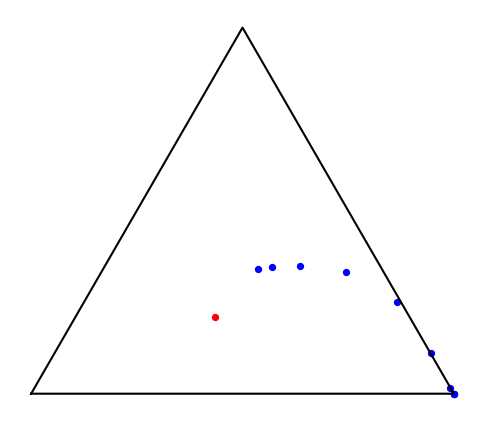

In [ ]:
plot_simplex(np.array(probs), q0)

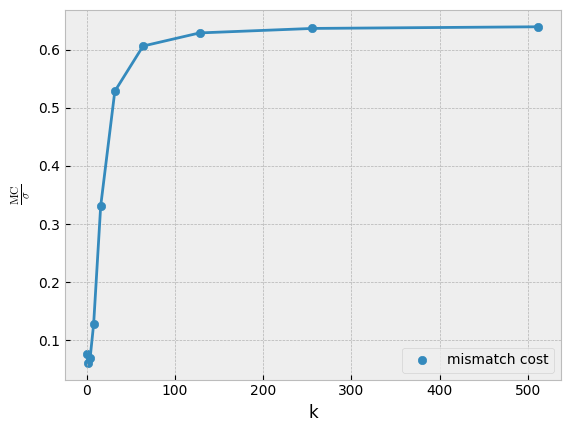

In [ ]:
MC = np.array(MC)
residual = np.array(residual)

plt.style.use('bmh')
plt.scatter(2**np.arange(10), MC/(MC+residual), label = 'mismatch cost')
plt.plot(2**np.arange(10), MC/(MC+residual))
plt.xlabel('k')
plt.ylabel(r'$\frac{\mathrm{MC}}{\sigma}$')
#plt.scatter(2**np.arange(10), residual, label = 'residual')
#plt.plot(2**np.arange(10), residual)

plt.legend()
plt.savefig("my_plot.pdf")
plt.show()

# Prior distribution for communication channels

The total mismatch cost in the communication channel is given by,

\begin{equation}
MC(p_X) = I(X; Y) + D(p_X\|q^a_X) + D(p_Xp_Y\|q^b_{XY}) - D(p_Y\|q^b_Y)
\end{equation}

The total entropy production can be written as,

\begin{equation}
\sigma(p_0) = \sum_{x\in X} f(x)p_0(x) + S(p_1)-S(p_0)
\end{equation}

Estimating the prior $q^b_{XY}$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr

In [ ]:
f = 0.001
X = [0, 1, 2, 3]
dl = 0.00001
noise = [[1-f, f], [f, 1-f]]
G_C = np.matrix([[1-f, f, 0, 0], [f, 1-f, 0, 0], [0, 0, 1-f, f], [0, 0, f, 1-f]])

In [ ]:
def KL(p, q):
  S = 0
  for i in range(len(p)):
    if p[i] != 0:
      S += p[i]*np.log(p[i]/q[i])
  return S

def fixed_point(fx):
  p0 = np.random.rand(len(fx))
  p0 = p0/np.sum(p0)
  epsilon = 0.00000001
  p2 = p0
  while True:
    pp = np.array(G_C@p0)[0]
    pow = np.array([[pp[i]**G_C[i,j] for j in X] for i in X])
    g1 = np.prod(pow, axis=0)
    lam = np.log(np.dot(np.exp(-fx), 1/g1))
    p1 = np.exp(-lam - fx)*1/g1
    if np.sum(np.abs(p1-p2)) < epsilon or np.sum(np.abs(p1-p0)) < epsilon:
      break
    p2 = p0
    p0 = p1
    #print(p0)
  return p1#, p0
    #print(p0)

def draw_fx(highminuslow):
  a = np.random.rand()
  b = a + highminuslow
  fx = np.zeros(4)
  if a > b:
    fx[0] = a
    fx[1] = a
    fx[2] = b
    fx[3] = b

  else:
    fx[0] = b
    fx[1] = b
    fx[2] = a
    fx[3] = a
  return fx

In [ ]:
def MC(px, qb, qa):
  pxy = np.array([[px[i]*noise[j][i] for j in [0,1]] for i in [0,1]]).flatten()
  py = np.sum(np.reshape(pxy, (2, 2), order = 'C'), axis = 0)
  qb_y = np.sum(np.reshape(qb, (2, 2), order = 'C'), axis = 0)
  pxy_prod = np.array([[px[i]*py[j] for j in [0, 1]] for i in [0, 1]]).flatten()
  MI = np.sum(rel_entr(pxy, pxy_prod))
  MMC = MI + KL(px, qa) + KL(pxy_prod, qb) - KL(py, qb_y)
  return MMC, MI, pxy_prod, pxy #, KL(pxy_prod, qb) - KL(py, qb_y)

In [ ]:
def draw_qb(highminuslow):
  #a = np.random.rand()
  a = 0.25
  b = a + highminuslow
  qb = np.zeros(4)
  # qb[0] = a
  # qb[2] = b
  # qb[1] = a
  # qb[3] = b
  if a < b:
    qb[0] = a
    qb[1] = a
    qb[2] = b
    qb[3] = b
  else:
    qb[0] = b
    qb[1] = b
    qb[2] = a
    qb[3] = a
  return qb/np.sum(qb)


[0.3496137  0.21960874 0.24562066 0.1851569 ]


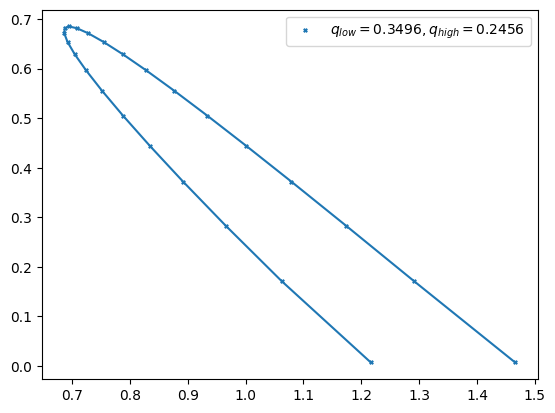

[27.53586492 27.53586492  2.53586492  2.53586492]
[0.3496137  0.21960874 0.24562066 0.1851569 ]


In [ ]:

fx = 5*draw_fx(5)
MMC_list = []
MI_list = []
EP_TOTAL = []
qa = np.array([0.5, 0.5])
#qb = fixed_point(fx)
#qb = draw_qb(0)
qb = np.random.rand(4)
qb = qb/np.sum(qb)
print(qb)
for p in np.linspace(0.001, 0.999, 25):
  px = np.array([p, 1-p])
  MMC, MI, pxy_prod, pxy = MC(px, qb, qa)
  MMC_list.append(MMC)
  MI_list.append(MI)
  EP_TOTAL.append(np.dot(fx, pxy_prod) + np.dot(np.log(pxy), pxy) - np.dot(np.log(pxy_prod), pxy_prod))


plt.scatter(MMC_list, MI_list, label = r'$q_{low} = %0.4f, q_{high} = %0.4f$'%(qb[0], qb[2]), marker = 'x', s = 6)
plt.plot(MMC_list, MI_list)
plt.legend()
plt.show()
print(fx)
print(qb)
